# Trading Strategies powered by Machine Learning - Support Vector Regression

## Support Vector Classifier with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv
pd.options.mode.chained_assignment = None  # default=

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


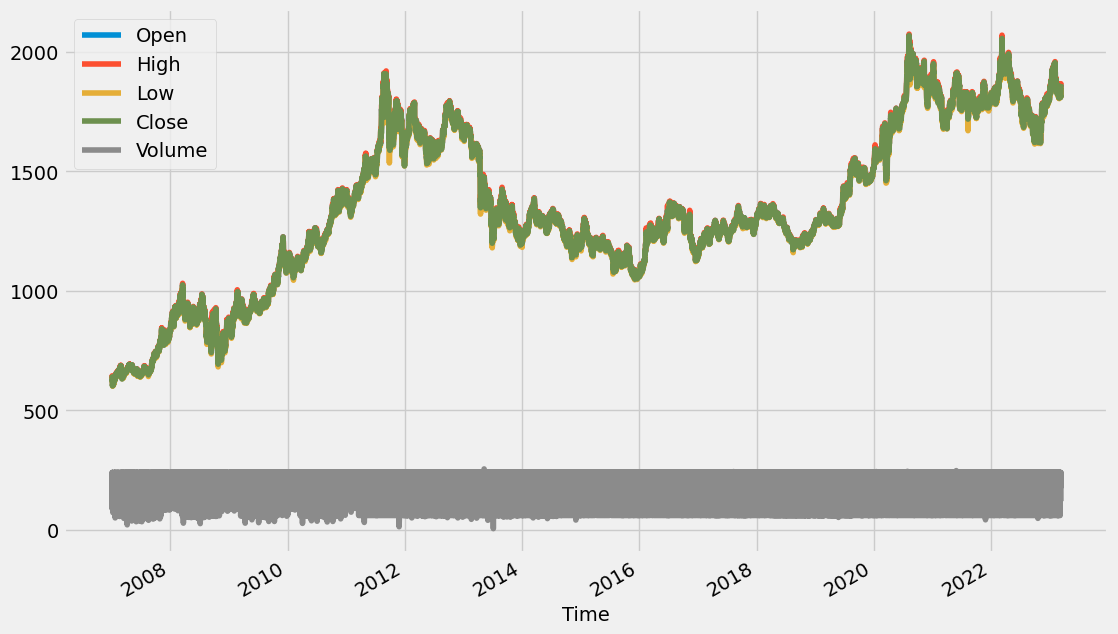

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Support_Vector_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            if self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [10]:
strategy = Support_Vector_Regression
account_size = 2000
folder_ML_Strategy = 'Support Vector Regression'

In [11]:
from sklearn.svm import SVR
from backtesting import Backtest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8")


class ML_SVR():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, future_days=1):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.future_days = future_days

    def Train_Model(self):
        df = self.data.copy()

        df[str(self.future_days) +
           '_Day_Price_Forecast'] = df['Close'].shift(-self.future_days)

        # Drop rows with NaN in the newly created column
        df.dropna(subset=[str(self.future_days) +
                  '_Day_Price_Forecast'], inplace=True)

        # Features (Close price as input)
        X = df[['Close']].copy()  # Corrected X to be a DataFrame
        Y = df[str(self.future_days) + '_Day_Price_Forecast'].copy()  # Target

        # Split data into train and test
        self.data_train = df.loc[self.start_train:self.end_train].copy()
        self.data_test = df.loc[self.start_test:self.end_test].copy()

        x_train = self.data_train[['Close']]
        y_train = Y.loc[self.start_train:self.end_train]
        x_test = self.data_test[['Close']]

        # Initialize and train the SVR model
        self.model = SVR(kernel='rbf', C=1e3, gamma=0.00001)
        self.model.fit(x_train, y_train)  # Removed unnecessary indexing

        # Make predictions
        self.data_train['Close_pred'] = self.model.predict(x_train)
        self.data_test['Close_pred'] = self.model.predict(x_test)

    
    def Add_Signal(self) :

        self.data_train['pred'] = np.where(
            (self.data_train['Close_pred'] > self.data_train['Close'] ), 1, -1)
        self.data_test['pred'] = np.where(
            (self.data_test['Close_pred'] > self.data_test['Close']), 1, -1)

    def Backtest(self, data, account_size=2000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 2000)
        result = backtest.run()
        return result

    def Run(self):
        self.Train_Model()
        self.Add_Signal()

        result_train = self.Backtest(self.data_train)
        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [12]:
ML_Class = ML_SVR

## TF D1

In [13]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [14]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [15]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_4464\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_4464\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [16]:
train

Start                     2007-01-01 00:00:00
End                       2020-12-31 00:00:00
Duration                   5113 days 00:00:00
Exposure Time [%]                    99.95417
Equity Final [$]                     3817.919
Equity Peak [$]                      3882.539
Return [%]                           90.89595
Buy & Hold Return [%]              198.417468
Return (Ann.) [%]                    3.804136
Volatility (Ann.) [%]                7.301537
Sharpe Ratio                         0.521005
Sortino Ratio                        0.763429
Calmar Ratio                         0.153058
Max. Drawdown [%]                  -24.854133
Avg. Drawdown [%]                    -1.09835
Max. Drawdown Duration     3258 days 00:00:00
Avg. Drawdown Duration       52 days 00:00:00
# Trades                                   85
Win Rate [%]                        68.235294
Best Trade [%]                     152.299126
Worst Trade [%]                     -3.269289
Avg. Trade [%]                    

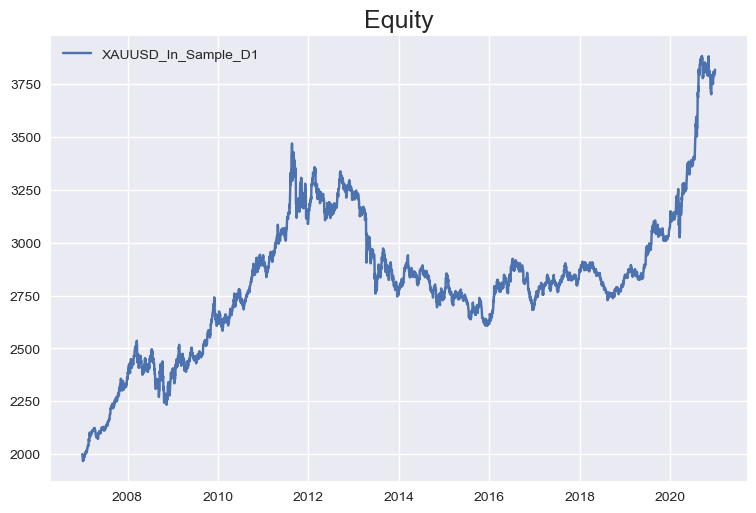

In [17]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [18]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                     2691.055
Equity Peak [$]                      2831.872
Return [%]                           34.55275
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                    7.847236
Volatility (Ann.) [%]               11.499324
Sharpe Ratio                         0.682408
Sortino Ratio                        1.082416
Calmar Ratio                          0.69978
Max. Drawdown [%]                  -11.213854
Avg. Drawdown [%]                    -2.12456
Max. Drawdown Duration      647 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                   59
Win Rate [%]                        61.016949
Best Trade [%]                      15.002669
Worst Trade [%]                    -10.090226
Avg. Trade [%]                    

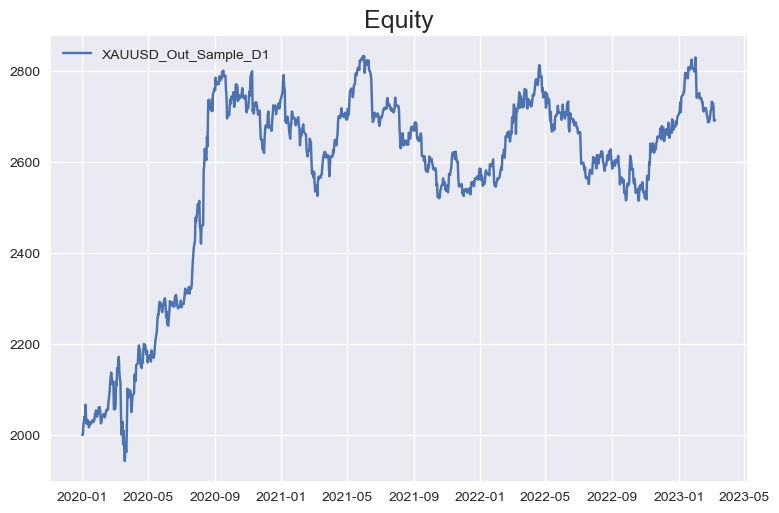

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [24]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [25]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [26]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_4464\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_4464\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [27]:
train

Start                     2007-01-01 00:00:00
End                       2020-12-31 20:00:00
Duration                   5113 days 20:00:00
Exposure Time [%]                   99.991101
Equity Final [$]                     3309.944
Equity Peak [$]                      3386.391
Return [%]                            65.4972
Buy & Hold Return [%]              198.626901
Return (Ann.) [%]                    2.951354
Volatility (Ann.) [%]                 8.34043
Sharpe Ratio                         0.353861
Sortino Ratio                        0.514077
Calmar Ratio                         0.113538
Max. Drawdown [%]                  -25.994327
Avg. Drawdown [%]                   -0.966703
Max. Drawdown Duration     2166 days 04:00:00
Avg. Drawdown Duration       26 days 01:00:00
# Trades                                  391
Win Rate [%]                        57.033248
Best Trade [%]                      86.660036
Worst Trade [%]                    -16.568827
Avg. Trade [%]                    

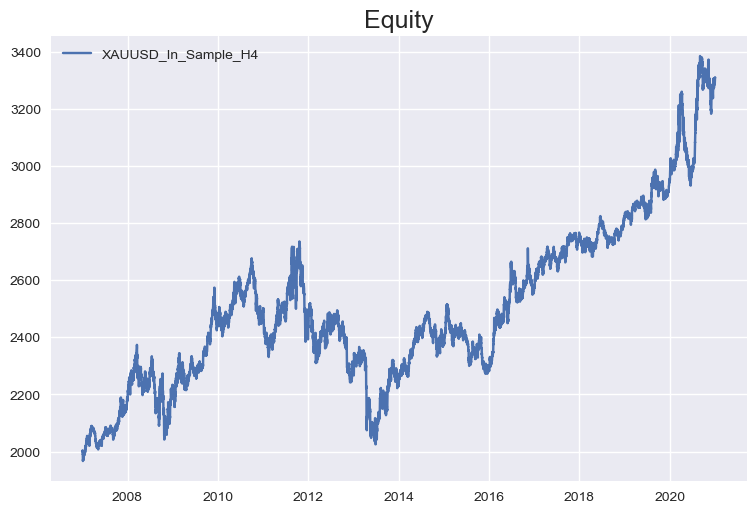

In [28]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [29]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                      2250.19
Equity Peak [$]                      2450.655
Return [%]                            12.5095
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                    3.042605
Volatility (Ann.) [%]               12.006462
Sharpe Ratio                         0.253414
Sortino Ratio                        0.369454
Calmar Ratio                         0.186807
Max. Drawdown [%]                  -16.287401
Avg. Drawdown [%]                   -2.870478
Max. Drawdown Duration      595 days 00:00:00
Avg. Drawdown Duration       44 days 12:00:00
# Trades                                  115
Win Rate [%]                        36.521739
Best Trade [%]                      15.187024
Worst Trade [%]                    -13.173335
Avg. Trade [%]                    

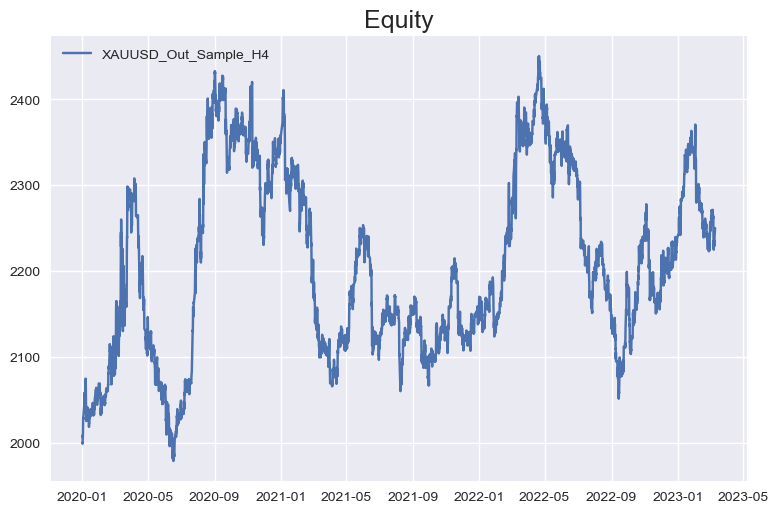

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [31]:
filename_train = f'result_{TF}_In_Sample.csv'

In [32]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [33]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [34]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [35]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [36]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [37]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

Start                     2007-01-01 00:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 21:00:00
Exposure Time [%]                   99.997648
Equity Final [$]                     3065.143
Equity Peak [$]                      3142.733
Return [%]                           53.25715
Buy & Hold Return [%]              198.567235
Return (Ann.) [%]                    2.494376
Volatility (Ann.) [%]                8.412927
Sharpe Ratio                         0.296493
Sortino Ratio                        0.427241
Calmar Ratio                         0.098072
Max. Drawdown [%]                  -25.434142
Avg. Drawdown [%]                   -0.652082
Max. Drawdown Duration     2021 days 01:00:00
Avg. Drawdown Duration       17 days 06:00:00
# Trades                                  924
Win Rate [%]                        56.926407
Best Trade [%]                      83.770262
Worst Trade [%]                    -16.507396
Avg. Trade [%]                    

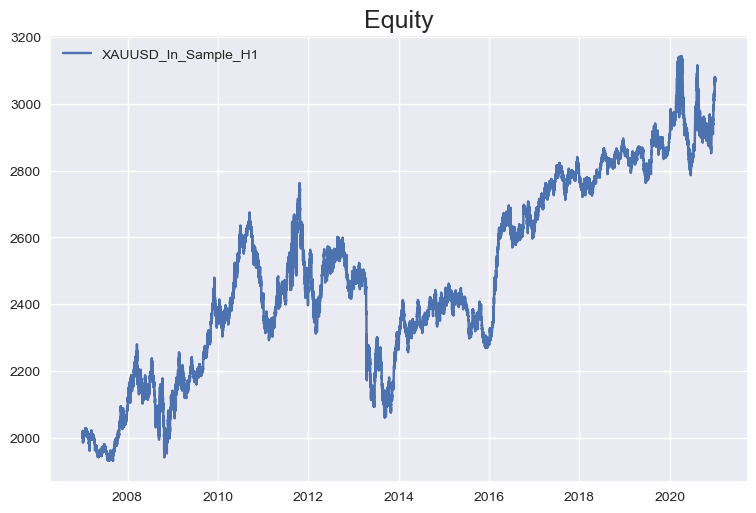

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                     1887.232
Equity Peak [$]                      2238.447
Return [%]                            -5.6384
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                   -1.464952
Volatility (Ann.) [%]               12.686312
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.127794
Avg. Drawdown [%]                   -1.171407
Max. Drawdown Duration     1068 days 06:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                  363
Win Rate [%]                         46.00551
Best Trade [%]                        9.54118
Worst Trade [%]                       -9.5133
Avg. Trade [%]                    

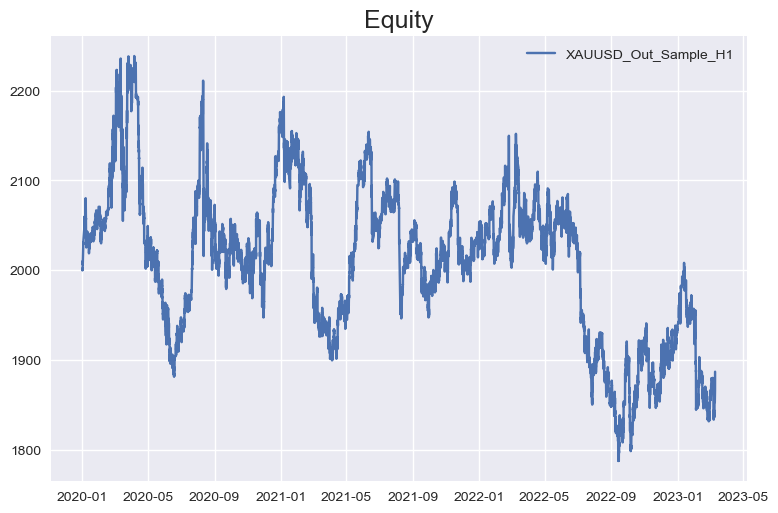

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [ ]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_3676\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_3676\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [ ]:
train

Start                     2007-01-01 00:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 21:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                       2313.9
Equity Peak [$]                      2975.355
Return [%]                             15.695
Buy & Hold Return [%]               198.63677
Return (Ann.) [%]                    0.842823
Volatility (Ann.) [%]                9.016123
Sharpe Ratio                         0.093479
Sortino Ratio                        0.130632
Calmar Ratio                          0.02234
Max. Drawdown [%]                  -37.726288
Avg. Drawdown [%]                    -0.58012
Max. Drawdown Duration     3404 days 07:00:00
Avg. Drawdown Duration       16 days 07:30:00
# Trades                                 1685
Win Rate [%]                        44.094955
Best Trade [%]                       45.17706
Worst Trade [%]                    -21.327995
Avg. Trade [%]                    

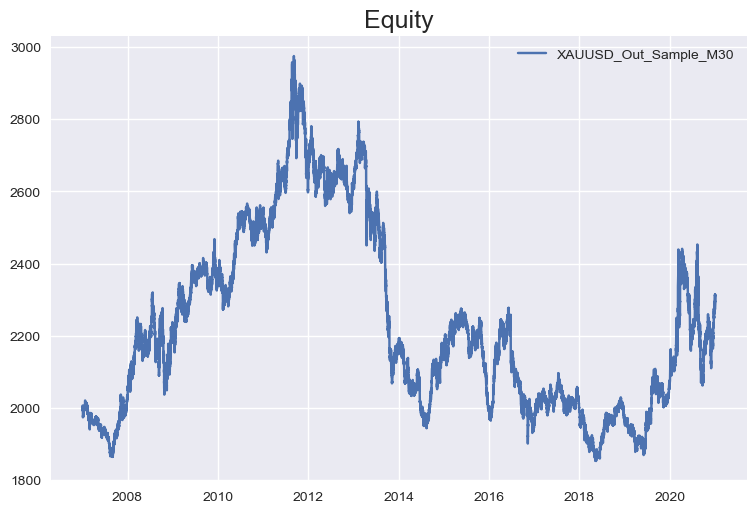

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1850.364
Equity Peak [$]                      2381.821
Return [%]                            -7.4818
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                   -1.958047
Volatility (Ann.) [%]               13.446029
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -32.513275
Avg. Drawdown [%]                   -1.150304
Max. Drawdown Duration      942 days 02:30:00
Avg. Drawdown Duration       18 days 09:20:00
# Trades                                  761
Win Rate [%]                        41.392904
Best Trade [%]                      10.791837
Worst Trade [%]                     -9.999588
Avg. Trade [%]                    

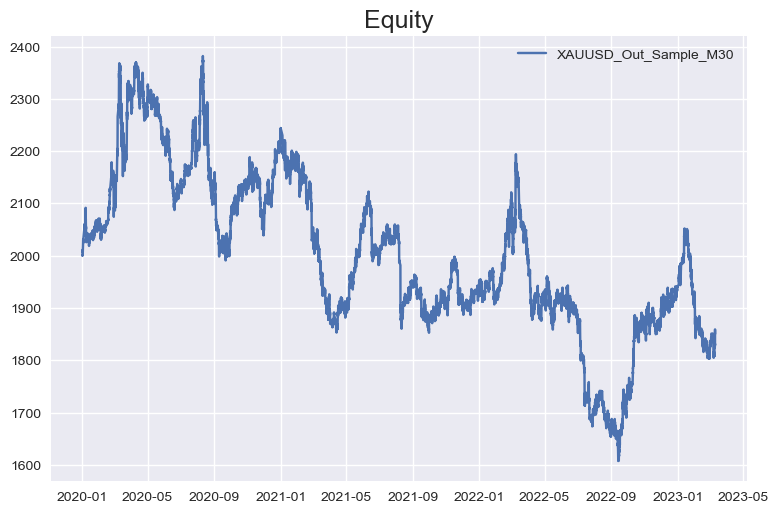

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [ ]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_3676\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_3676\2614928540.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [ ]:
train

Start                     2014-09-23 13:00:00
End                       2020-12-31 21:45:00
Duration                   2291 days 08:45:00
Exposure Time [%]                   99.998651
Equity Final [$]                     2599.041
Equity Peak [$]                      2737.124
Return [%]                           29.95205
Buy & Hold Return [%]                54.80914
Return (Ann.) [%]                    3.407516
Volatility (Ann.) [%]                8.260396
Sharpe Ratio                         0.412512
Sortino Ratio                        0.585889
Calmar Ratio                         0.173044
Max. Drawdown [%]                  -19.691658
Avg. Drawdown [%]                    -0.32825
Max. Drawdown Duration      841 days 22:30:00
Avg. Drawdown Duration        5 days 19:55:00
# Trades                                  982
Win Rate [%]                        60.997963
Best Trade [%]                      38.379723
Worst Trade [%]                     -8.885877
Avg. Trade [%]                    

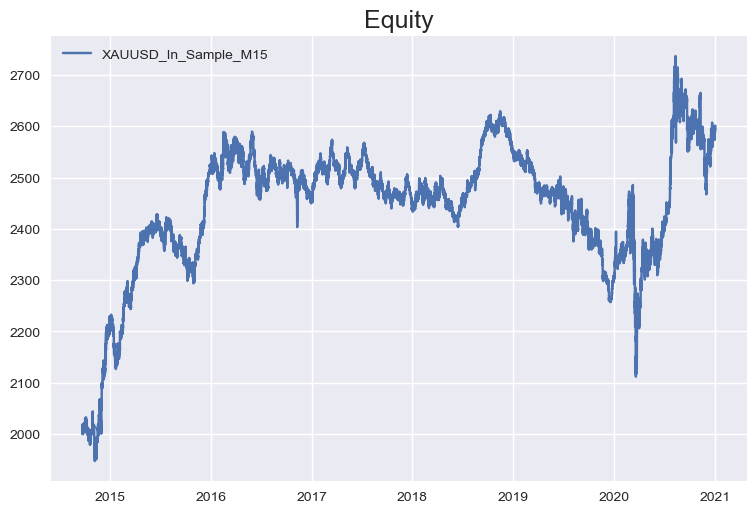

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                     2312.042
Equity Peak [$]                      2484.892
Return [%]                            15.6021
Buy & Hold Return [%]               22.665911
Return (Ann.) [%]                    3.772777
Volatility (Ann.) [%]                13.02204
Sharpe Ratio                         0.289722
Sortino Ratio                        0.406378
Calmar Ratio                          0.22015
Max. Drawdown [%]                  -17.137303
Avg. Drawdown [%]                   -0.809316
Max. Drawdown Duration      575 days 00:00:00
Avg. Drawdown Duration       10 days 22:48:00
# Trades                                   47
Win Rate [%]                        42.553191
Best Trade [%]                      38.379723
Worst Trade [%]                     -8.486801
Avg. Trade [%]                    

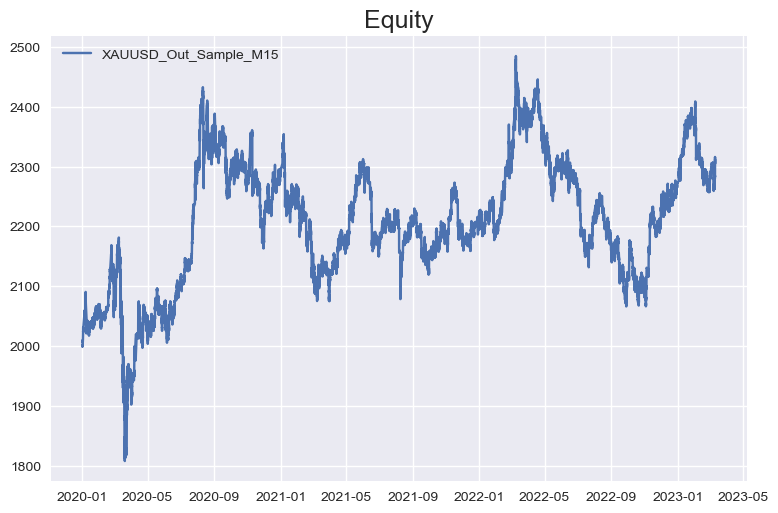

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')